# Expression Evaluation (On-Disk)

ironArray has transparent support for the evaluation of expressions whose operands are disk-based.  The main advantage of this is that you can perform operations with data that exceeds your available memory (even in compressed state).

On the other hand, disks are pretty much slower beasts than memory (although with the advent of SSDs, the gap is closing significantly during the last few years), so you should expect evaluation speeds going down significantly, but due to the on-the-fly compression, perhaps to as much as you can imagine.



In [1]:
%load_ext memprofiler
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import iarray as ia
from ipython_memwatcher import MemWatcher

mw = MemWatcher()
mw.start_watching_memory()
meas = {}

In [1] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 187.629 MiB


Let's start providing some hints on what kind of speed you can expect from using ironArray with on-disk data.  So as to show this, we are going to use our original on-disk array and will create an on-disk outcome where we will put the result of our operations:

In [2]:
ia_precip = ia.open("precip-3m.iarr")
precip1 = ia_precip[0]
precip2 = ia_precip[1]
precip3 = ia_precip[2]

In [2] used 4.324 MiB RAM in 0.032s, peaked 0.000 MiB above current, total RAM usage 191.953 MiB


In this case, we are just getting views of the larger array that is on-disk.  Remember that views do not create new containers, so this is why the above operation is fast.  Now, let's build the expression for the mean values:

In [3]:
precip_mean = (precip1 + precip2 + precip3) / 3

In [3] used 0.309 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 192.262 MiB


and now let's evaluate and make sure that the result is created on-disk:

In [4]:
with ia.config(storage=ia.Storage(filename="mean-3m.iarr")) as cfg:
    precip_mean_disk = precip_mean.eval(cfg=cfg)
precip_mean

In [4] used 32.898 MiB RAM in 10.658s, peaked 40.211 MiB above current, total RAM usage 225.160 MiB


In [5]:
meas["ia_mean_disk"] = mw.measurements

In [5] used 0.004 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 225.164 MiB


We see that evaluation from disk takes quite more time than operating in memory, but this is kind of expected.  What we are more interested here is the amount of RAM needed to perform the evaluation has less than 100 MB (33 + 40 MB), whereas the output array is quite larger than this:

In [6]:
%ls -lh mean-3m.iarr

-rw-r--r-- 1 faltet faltet 1.2G Jan 20 13:11 mean-3m.iarr
In [6] used 0.773 MiB RAM in 0.233s, peaked 0.000 MiB above current, total RAM usage 225.938 MiB


So, with a result size of more than 1 GB, it well above than the consumed memory.  This memory is probably being required by array temporaries (which Python takes some time to release back), so in the long run this figure should be considered more a temporary peak that will be eventually reclaimed by the interpreter for other uses.  But still, it is important to realize that such amount of memory is needed.

For the sake of comparison, let's see how similar array libraries perform at this.  Zarr is the most obvious container because it supports the same Blosc compressor, so this will allow for a apple to apple comparison.  Let's create a Zarr container out of our current one:

In [7]:
import zarr
from functools import reduce
ia_defs = ia.Config()

In [7] used 2.031 MiB RAM in 0.037s, peaked 0.000 MiB above current, total RAM usage 227.969 MiB


In [8]:
blocksize = reduce(lambda x, y: x * y, ia_precip.blockshape) * np.dtype(np.float32).itemsize
zarr_precip = zarr.open(
    "precip-3m.zarr", "w", shape=ia_precip.shape, chunks=ia_precip.chunkshape, dtype=ia_precip.dtype,
    compressor=zarr.Blosc(clevel=ia_defs.clevel, cname="lz4", blocksize=blocksize),
)

In [8] used 0.039 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 228.008 MiB


and populate it with the ironArray data:

In [9]:
ia_precip.copyto(zarr_precip)

In [9] used 18.168 MiB RAM in 6.575s, peaked 0.000 MiB above current, total RAM usage 246.176 MiB


and now do the mean by using Dask:

In [10]:
import dask
import dask.array as da

In [10] used 3.832 MiB RAM in 0.097s, peaked 0.000 MiB above current, total RAM usage 250.008 MiB


In [11]:
precip_mean_disk = ia.open("mean-3m.iarr")
blocksize = reduce(lambda x, y: x * y, precip_mean_disk.blockshape) * np.dtype(np.float32).itemsize
shape = precip_mean_disk.shape
chunks = precip_mean_disk.chunkshape
dtype = np.float32
clevel = ia_defs.clevel

In [11] used -11.816 MiB RAM in 0.030s, peaked 0.000 MiB above current, total RAM usage 238.191 MiB


In [12]:
with dask.config.set(scheduler="threads"):
    precip = zarr.open("precip-3m.zarr")
    d = da.from_zarr(precip)
    precip1 = d[0]
    precip2 = d[1]
    precip3 = d[2]
    res = (precip1 + precip2 + precip3) / 3
    zarr_precip_mean_disk = zarr.open(
        "mean-3m.zarr",
        "w",
        shape=shape,
        chunks=chunks,
        dtype=dtype,
        compressor=zarr.Blosc(clevel=clevel, cname="lz4", blocksize=blocksize),
    )
    da.to_zarr(res, zarr_precip_mean_disk)

In [12] used 547.074 MiB RAM in 2.262s, peaked 69.184 MiB above current, total RAM usage 785.266 MiB


In [13]:
meas["dask_mean_disk"] = mw.measurements

In [13] used 0.012 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 785.277 MiB


In this case we see that Dask+Zarr took about 3x more time than ironArray in performing the operations.  But perhaps more importantly, Dask+Zarr took a considerable about of peak RAM to complete the operation (more than 10 GB), which is much more than ironArray (around 100 MB).

Here it is a comparison of the times on a plot:

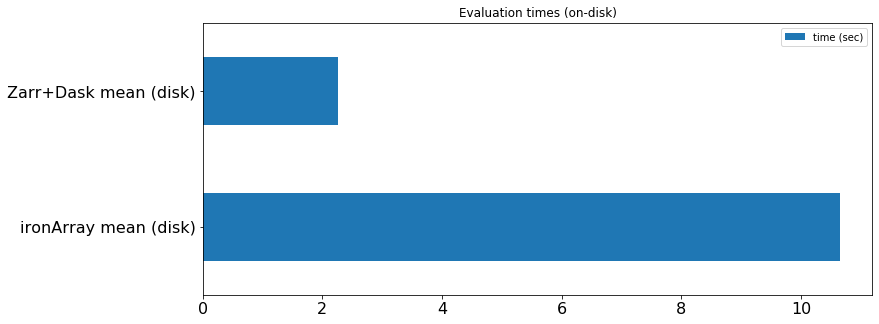

In [14] used 16.828 MiB RAM in 0.295s, peaked 0.000 MiB above current, total RAM usage 802.105 MiB


In [14]:
%matplotlib inline
import pandas as pd

labels = ["ironArray mean (disk)", "Zarr+Dask mean (disk)"]
df = pd.DataFrame({'time (sec)': [
    meas["ia_mean_disk"].time_delta, meas["dask_mean_disk"].time_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Evaluation times (on-disk)")

And here the memory consumption for ironArray:

rm: cannot remove 'iarray_mean_disk.dat': No such file or directory
mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


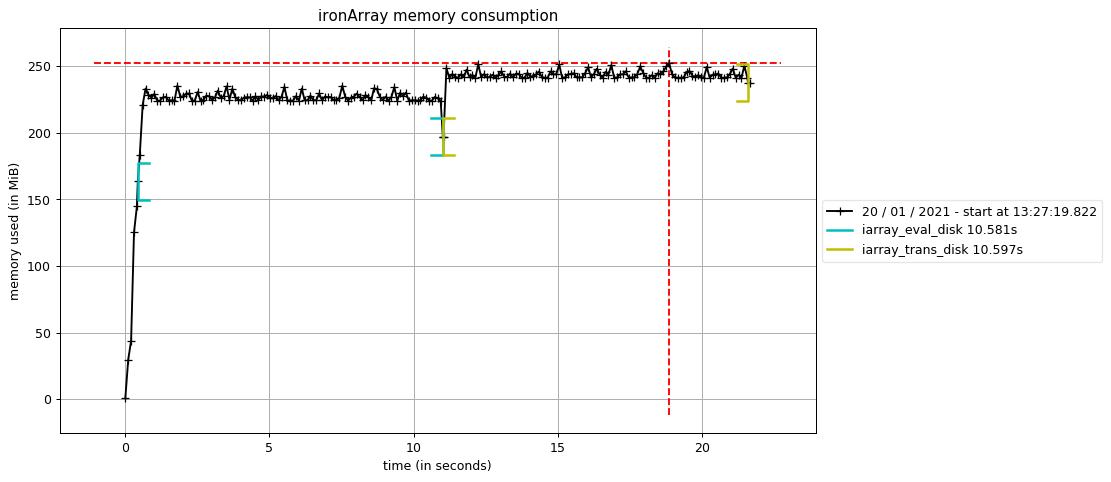

In [15] used 3.734 MiB RAM in 22.168s, peaked 0.000 MiB above current, total RAM usage 805.840 MiB


In [15]:
%rm iarray_mean_disk.dat
%run -m mprof run -o iarray_mean_disk.dat iarray_mean_disk.py
%run -m mprof plot iarray_mean_disk.dat -t "ironArray memory consumption"

In this case we see that the first operation consumes a good amount of memory (100 MB), while the second is much more contained about it (~30 MB).  This is possibly due to some warm-up effects during the first operation; after that, you should expect rather little memory usage with ironArray.

Let's do the same operations with dask:

rm: cannot remove 'dask_mean_disk.dat': No such file or directory
mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


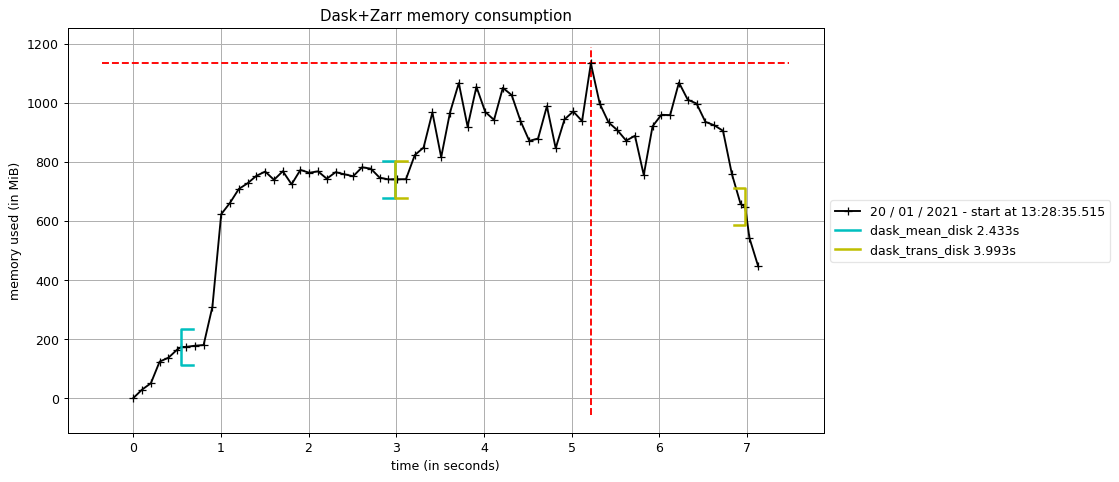

In [16] used 2.754 MiB RAM in 7.633s, peaked 0.000 MiB above current, total RAM usage 808.594 MiB


In [16]:
%rm dask_mean_disk.dat
%run -m mprof run -o dask_mean_disk.dat dask_mean_disk.py
%run -m mprof plot dask_mean_disk.dat -t "Dask+Zarr memory consumption"

One can see how ironArray is very efficient in terms of memory usage (220 MB vs 14 GB that uses Dask).  That means that ironArray can complete very large on-disk computations without a need to have large amounts of RAM in the host.

This is a general feature of ironArray: perform evaluations fast while keeping memory usage low.  This allows to compute operations on arbitrarily large arrays (as long as disk storage allows) without worrying about RAM capacities.

## Optimization Tips

Even if ironArray has been very competitive in terms of speed and memory consumption, so far the computations have been done using just the default values.  Let's see how we can accelerate things here.

One aspect that we have seen the sections above is that computation from disk is much slower than from memory.  In this section we want to explore how we can accelerate the on-disk performance as much as possible.  We know that larger chunks tend to accelerate I/O (because sequential access is faster than random access).  Here are the current chunk and block shapes:

In [2]:
ia_precip = ia.open("precip-3m.iarr")
ia_precip.info

type                : IArray
shape               : (3, 720, 721, 1440)
chunkshape          : (1, 64, 64, 128)
blockshape          : (1, 16, 16, 64)
In [2] used 4.191 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 101.645 MiB


But if you remember from the tutorial on reductions, we already reached to kind of 'optimal' chunks for reductions:

In [3]:
ia_precip_opt = ia.open("precip-3m-optimal.iarr")
ia_precip_opt.info

type                : IArray
shape               : (3, 720, 721, 1440)
chunkshape          : (1, 360, 128, 1440)
blockshape          : (1, 8, 8, 720)
In [3] used 4.047 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 109.223 MiB


In this case, the chunks are considerably larger.  Let's see how this effects to our computations:

In [6]:
precip1 = ia_precip_opt[0]
precip2 = ia_precip_opt[1]
precip3 = ia_precip_opt[2]

In [6] used 0.039 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 139.602 MiB


In [8]:
precip_mean = (precip1 + precip2 + precip3) / 3
with ia.config(storage=ia.Storage(filename="mean-3m-optimal.iarr")) as cfg:
    precip_mean_disk = precip_mean.eval(cfg=cfg)
precip_mean

In [8] used 784.266 MiB RAM in 42.282s, peaked 0.000 MiB above current, total RAM usage 1952.207 MiB


Ok, so no luck here.  The reason maybe is that too large chunks can lead to L3 cache overflows when doing the operations.  Perhaps it is better to be a bit more conservative and try with just a 4x larger chunk:

In [8]:
with ia.config(chunkshape=(1, 128, 128, 128), blockshape=(1, 16, 16, 64), filename="precip-3m-test.iarr") as cfg:
    new_precip = ia_precip.copy(cfg=cfg)

In [8] used 24.109 MiB RAM in 19.390s, peaked 0.000 MiB above current, total RAM usage 681.012 MiB


Redo the in-memory computation:

In [9]:
precip1 = new_precip[0].copy()
precip2 = new_precip[1].copy()
precip3 = new_precip[2].copy()
precip_mean = (precip1 + precip2 + precip3) / 3

In [9] used 1513.531 MiB RAM in 13.690s, peaked 0.000 MiB above current, total RAM usage 2194.543 MiB


In [10]:
precip_mean = precip_mean.eval()

In [10] used 1274.191 MiB RAM in 1.839s, peaked 0.000 MiB above current, total RAM usage 3468.734 MiB


And now, redo the on-disk evaluation:

In [11]:
precip1 = new_precip[0]
precip2 = new_precip[1]
precip3 = new_precip[2]
precip_mean = (precip1 + precip2 + precip3) / 3
with ia.config(storage=ia.Storage(filename="mean-3m-optimal.iarr")) as cfg:
    precip_mean_disk = precip_mean.eval(cfg=cfg)

In [11] used -1696.281 MiB RAM in 17.191s, peaked 1696.281 MiB above current, total RAM usage 1772.453 MiB


So, we see that the times do not change too much for either in-memory or on-disk evaluations.  Behind the scenes, the writer of this tutorial tried different configurations, but timings did not improve significantly.  That means that the defaults that are set automatically are generally good enough for most of the expressions out there.

Before closing, let us remember that the mean that we are evaluating is just a reduction, so maybe we can have a better luck with using the reduction machinery.  Let's do that with the optimal chunk and block shapes that we have determined before:

In [3]:
precip_opt = ia.open("precip-3m-optimal.iarr")
precip_opt_mem = precip_opt.copy()

/Users/faltet/miniconda3/envs/iarray/lib/python3.8/site-packages/ipython_memwatcher-0.3.0-py3.8.egg/ipython_memwatcher/memwatcher.py SOMETHING WEIRD HAPPENED AND THIS RAN FOR TOO LONG, THIS THREAD IS KILLING ITSELF
In [3] used 2152.809 MiB RAM in 80.043s, peaked 0.000 MiB above current, total RAM usage 2213.711 MiB


First, for in-memory:

In [4]:
%%mprof_run -i 0.1 reduc_mem

reduc1 = ia.mean(precip_opt_mem, axis=(3, 2, 0))

In [4] used 60.660 MiB RAM in 1.265s, peaked 0.000 MiB above current, total RAM usage 2274.371 MiB
Memory usage: 18.6836 MiB
Elapsed time: 1.3663 s
In [4] used 0.004 MiB RAM in 1.366s, peaked 0.000 MiB above current, total RAM usage 2274.375 MiB


Let's see how much memory this is using:

In [6]:
%mprof_plot reduc_mem

In [6] used 0.074 MiB RAM in 0.013s, peaked 0.000 MiB above current, total RAM usage 2294.176 MiB


rm: iarray_reduc_memory.dat: No such file or directory
mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
In [5] used 12.262 MiB RAM in 82.140s, peaked 0.000 MiB above current, total RAM usage 984.852 MiB


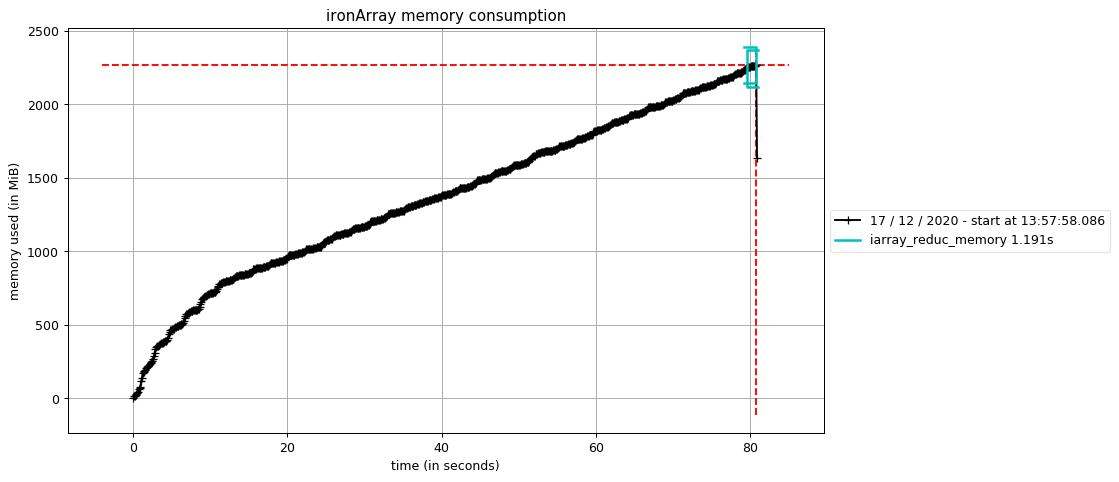

In [5]:
%rm iarray_reduc_memory.dat
%run -m mprof run -o iarray_reduc_memory.dat iarray_reduc_memory.py
%run -m mprof plot iarray_reduc_memory.dat -t "ironArray memory consumption"

TODO: spot a way to measure just the memory samples in a cell

Then, for on-disk:

In [7]:
%%mprof_run -i 0.1 reduc_disk

# This does not create the output yet (https://github.com/inaos/iron-array/issues/380)
with ia.config(storage=ia.Storage(filename="reduc-3m-optimal.iarr")) as cfg:
    reduc2 = ia.mean(precip_opt, axis=(3, 2, 0), cfg=cfg)

In [7] used 537.453 MiB RAM in 3.430s, peaked 0.000 MiB above current, total RAM usage 2831.629 MiB
Memory usage: 537.4414 MiB
Elapsed time: 3.5368 s
In [7] used 0.000 MiB RAM in 3.536s, peaked 0.000 MiB above current, total RAM usage 2831.629 MiB


In [8]:
%mprof_plot reduc_mem reduc_disk

In [8] used 0.039 MiB RAM in 0.009s, peaked 0.000 MiB above current, total RAM usage 2831.668 MiB


In [ ]:
mw.stop_watching_memory()